# Initial Conditions

To run a simulation we need something to run... 

Simulations need initial conditions (ICs) that define the positions and properties of particles of various species. In this workshop, we won't work through the entire process of making legitimate ICs with matter distributions consistent with our own Universe and cosmology. Later on, we will use some legitimate ICs, but to begin with, we will make some toy ICs to get an idea of the process.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import unyt
import scipy
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo

## Merging dark matter halos

To start with, let's ignore baryons (they're far too messy and get in the way). We can very easily create some initial conditions describing two merging dark matter halos, all we need to do is define the particle positions, velocities, and masses. In the cell below is a function that does just this. Take a look at what it does.

This function takes the mass of a particle in solar mass, the number of particles in each halo, the size of the box around the two halos (in comoving megaparsecs [cMpc]), the central positions of each halo in units of the box length, the size of each halo in units of the box length, and the magnitude of the velocity of each halo as arguments. You can set these freely but note that pathological setups may cause issues or indeed not run at all. Beyond the input arguments feel free to modify the code.

**BEWARE! Make the ICs too large and your computer will not be happy and the simulations will take too long to run if they don't crash your computer entirely!**

In [2]:
def make_merging_dm_halos(
    part_mass,
    npart1, 
    npart2, 
    boxsize, 
    halo1_pos, 
    halo2_pos, 
    halo1_size, 
    halo2_size, 
    halo1_vel, 
    halo2_vel
):
    """
    Make SWIFT initial conditions containing two dark matter halos.

    Args:
        part_mass (float)
            The mass of a particle in solar masses.
        npart1 (int)
            The number of particles in the dark matter halo.
        npart2 (int)
            The number of particles in the dark matter halo.
        boxsize (float)
            The size of the simulation box in Mpc.
        halo1_pos (array_like, float) [3]
            An array describing the position of a halo in units of the boxsize (i.e. 0 < halo1_pos < 1).
        halo2_pos (array_like, float) [3]
            An array describing the position of a halo in units of the boxsize (i.e. 0 < halo1_pos < 1).
        halo1_size (float)
            The size of the halo in units of the boxsize. This size is the standard deviation of the 
            Gaussian kernel used to define random particle positions.
        halo2_size (float)
            The size of the halo in units of the boxsize. This size is the standard deviation of the 
            Gaussian kernel used to define random particle positions.
        halo1_vel (float)
            The magnitude of a halo's velocity in km/s.
        halo2_vel (float)
            The magnitude of a halo's velocity in km/s.
    """

    # Convert quantities in boxsize units to cMpc
    halo1_pos *= boxsize
    halo2_pos *= boxsize
    halo1_size *= boxsize
    halo2_size *= boxsize

    # Define the particle positions for each halo.
    part1_pos = np.zeros((npart1, 3))
    part2_pos = np.zeros((npart2, 3))
    part1_pos[:, 0] = np.random.normal(loc=halo1_pos[0], scale=halo1_size, size=npart1)
    part1_pos[:, 1] = np.random.normal(loc=halo1_pos[1], scale=halo1_size, size=npart1)
    part1_pos[:, 2] = np.random.normal(loc=halo1_pos[2], scale=halo1_size, size=npart1)
    part2_pos[:, 0] = np.random.normal(loc=halo2_pos[0], scale=halo2_size, size=npart2)
    part2_pos[:, 1] = np.random.normal(loc=halo2_pos[1], scale=halo2_size, size=npart2)
    part2_pos[:, 2] = np.random.normal(loc=halo2_pos[2], scale=halo2_size, size=npart2)

    # Define some velocities, although not realistic we can start with all particles
    # having the same velocity as the bulk velocity of the halo + some random contribution.

    # To calculate velocities we need unit vectors to point the halos at each other
    direction_vectors = halo2_pos - halo1_pos
    normalized_direction_vectors = direction_vectors / np.linalg.norm(direction_vectors)

    # Calculate velocities...
    part1_vel = np.full_like(part1_pos, normalized_direction_vectors * halo1_vel)
    part2_vel = np.full_like(part2_pos, -normalized_direction_vectors * halo2_vel)

    # ... and add some random scatter from a velocity dispersion
    part1_vel += np.random.normal(loc=0, scale=100, size=(npart1, 3))
    part2_vel += np.random.normal(loc=0, scale=100, size=(npart2, 3))

    # Combine the halo arrays into single arrays
    pos = np.concatenate((part1_pos, part2_pos))
    vel = np.concatenate((part1_vel, part2_vel))

    # Create the particle mass array
    masses = np.full(npart1 + npart2, part_mass)

    print("Made halos with masses: log_10(M_1 / Msun) = "
          "%.2f & log_10(M_2 / Msun) = %.2f" % (np.log10(part_mass * npart1), np.log10(part_mass * npart2)))
    
    return pos, vel, masses

# Define the boxsize
boxsize = 5

# Calculate the part mass necessary to be consistent with cosmology
npart1 = 50000
npart2 = 10000
part_mass = (cosmo.Om(0) * cosmo.critical_density(0) * (boxsize * u.Mpc) ** 3 / (npart1 + npart2)).to(u.Msun).value

print((npart1 + npart2) * part_mass * u.Msun / (boxsize * u.Mpc) ** 3 / cosmo.critical_density(0).to(u.Msun / u.Mpc ** 3))

print("m_p =", part_mass)

# Make the halos
pos, vel, masses = make_merging_dm_halos(
    part_mass=part_mass,
    npart1=npart1, 
    npart2=npart2, 
    boxsize=boxsize, 
    halo1_pos=np.array([0.5, 0.5, 0.5]), 
    halo2_pos=np.array([0.75, 0.75, 0.75]), 
    halo1_size=0.025, 
    halo2_size=0.01, 
    halo1_vel=50, 
    halo2_vel=200
)

0.3096599999999999
m_p = 81964947.5333111
Made halos with masses: log_10(M_1 / Msun) = 12.61 & log_10(M_2 / Msun) = 11.91


Let's take a look at what we've made.

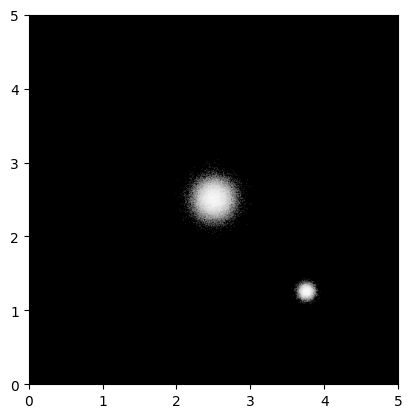

In [3]:
# Make a quick and dirty 2D histogram to visualise
H, _, _ = np.histogram2d(pos[:, 0], pos[:, 2], bins=np.arange(0, boxsize + 0.01, 0.01))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(np.arcsinh(H), cmap="Greys_r", extent=[0, boxsize, 0, boxsize])
plt.show()
plt.close()

Of course, what we've done here is simple make some arrays. Now we need to convert them into IC files that SWIFT will understand. 

## Initial condition format

SWIFT's (and many other simulations') ICs are in HDF5 format. This format is ubiquitous in theoretical astrophysics and computing in general due to its simplicity, Python interface (`h5py`), and ability to load subsets of data. 

The interface to HDF5 files in Python functions similar to dictionaries with data stored under keys and accessed using `hdf["key"]` syntax (with some caveats). We will show this below in a bit more detail, if you haven't come across HDF5 format files before it's worth getting familiar with them separately. It's an incredibly powerful data format.

We can convert what we've made above into ICs by making use of `swiftsimio`'s `Writer` utility. Below I've defined a function that takes what was created above and saves it as a HDF5 file.

In [4]:
from swiftsimio.units import cosmo_units
from swiftsimio import Writer


def make_dmo_ics(boxsize, pos, vel, masses):
    """
    Convert arrays describing the particle distribution to an IC file.
    """
    
    # Associate units to the arrays and boxsize
    boxsize *= unyt.Mpc
    pos *= unyt.Mpc
    vel *= unyt.km / unyt.s
    masses *= unyt.Msun

    # Generate object. cosmo_units corresponds to default Gadget-oid units
    # of 10^10 Msun, Mpc, and km/s
    ics = Writer(cosmo_units, boxsize, dimension=3)

    # Attach the particle arrays
    ics.dark_matter.coordinates = pos
    ics.dark_matter.velocities = vel
    ics.dark_matter.masses = masses

    # Finally, write the ICs
    ics.write("../ics/dmo_merger.hdf5")


make_dmo_ics(boxsize, pos, vel, masses)

There are a couple of things to note in the above. Firstly, `swiftsimio` makes use of unyt so we have associated all properties with their units to ensure consistency. Next, you'll see the `Writer` class is initialised with a `cosmo_units` object. This object encodes everything about the cosmological unit system and ensures that the initial conditions are correctly interpreted when SWIFT reads the ICs. Finally, you may have noticed we have only interacted with the `dark_matter` portion of the ICs. Next, we'll move on to those pesky baryons but first, take a look at [DMO Simulations](DMO_Simulations.ipynb) and then come back after completing the tutorial there.

## Adding Baryons to the halos

As neat and tidy as a dark matter only universe would be it, sadly, is not the Universe we study. Instead, we have a contribution from baryonic matter which makes up the observable portion of the Universe. Now let's introduce some baryons to the simulation so we can see how they are affected by the merger. 

To add baryons we will first need to read in the dark matter ICs from the above halos. To do so we will use `h5py`. 
- First, we open the HDF5 file and store this representation of the file in the `hdf` variable. Note that `"r"` tells `h5py` we want to read the data. The `hdf` object acts much like a dictionary.
- We then extract the data based on their keys. Dark matter is denoted as `PartType1` (gas is `PartType0`, stars are `PartType4` and black holes are `PartType5`) so we first need that key and then we want the key corresponding to the data such as `Coordinates` so we append that like a file path.
- We add `[:]` to the end to actually read the data, if we omit the square brackets entirely then we only store the `Dataset` in the variable, not the data itself. This is called lazy loading and enables the manipulation of extremely large datasets without reading all the data into memory. We could instead only extract a slice, say `[10:1000]`, or specific indices if we wanted.
- We then close the HDF5 file to ensure it does not get corrupted or left open.

_Of course, if you're paying attention you may have noticed we do not need to read the data again since the arrays are already in memory from above... but you will be manipulating HDF5 later so now is as good a time as any to cover it!_

In [5]:
import h5py

# Open the file
hdf = h5py.File("../ics/dmo_merger.hdf5", "r")

# Extract the data from before
dm_pos = hdf["PartType1/Coordinates"][:]
dm_vel = hdf["PartType1/Velocities"][:]
dm_masses = hdf["PartType1/Masses"][:]

hdf.close()

Now that we have the dark matter data we can use it create gas particles. To do so we will use the simplest possible method: split the dark matter particles by the cosmic baryon fraction into a dark matter particle and a baryon and randomly perturb the new baryon particles. This is a horrible simplification, baryons do not obey the same density profiles as dark matter in halos but then again, the profiles used above are also not representative of the density profiles of dark matter in halos either.

The function below will take the dark matter arrays and return arrays for the baryonic particles.

Now, for the messy bits... Baryons have other properties which we will need to set initial values for. We will do these by setting reasonably sensible randomised guesses, SWIFT will quickly recalculate them to be representative anyway. But there's an important concept to cover first...

Gas dominates the baryons in the Universe and this gas behaves as a fluid. Various simulations treat fluids in different ways with a myriad of different ways to solve hydrodynamics equations to describe the motion of fluids. SWIFT is a Smoothed Particle Hydrodynamics (SPH) code. This means it uses particles smoothed over a kernel to represent the fluid and solves the hydrodynamical equation of motions using these kernels. An important property of SPH particles is the smoothing length. This property describes the size of the kernel (or fluid element) the particle describes. In high-density environments the smoothing length is smaller, in low-density environments it is larger. In reality, the smoothing length of an SPH particle is defined based on its neighbouring SPH particles, SWIFT will recalculate smoothing lengths after reading in the initial conditions if we tell it to, so all we need to do is initialise it with something sensible so nothing breaks prior to that.

With all of these properties calculated we can now use `swiftsimio` again to create the ICs.

Assuming you have finished running your DMO simulation now and seen the video, if not go and do that, you can now go to [Hydrodynamical Simualtions](Hydro_Simulations.ipynb) and set up SWIFT to run a hydrodynamical version of the merger.